### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import tensorflow as tf
import logomaker
from time import time

import sequtils as su
import seq

### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[1000]] * 8
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               mutationProb=0.05, verbose=True)

Pattern ATGGCAAGAATTCAATCTACTGCAAATAAAGAA translates to  ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
  mutated to ATAGCAAGAATTCAATCTACTGCAAATAAAGAC and inserted in genome 0 contig 0 at position 615
  mutated to ATTGCCAGAATTCAATCAACCGCAAATAAAGAA and inserted in genome 1 contig 0 at position 497
  mutated to ATGGCAAGAATTCAATCTACTGCAAATAAGGAA and inserted in genome 2 contig 0 at position 36
  mutated to ATGGCAAGAATTCAATCCACCGCAAATAAAGAA and inserted in genome 3 contig 0 at position 131
  mutated to ATGGCAAGAATTCAGTCTACTGCAAATAAAGAA and inserted in genome 4 contig 0 at position 893
  mutated to ATGGCCAGAATTCAATCTACAGCAAATAAAGAA and inserted in genome 5 contig 0 at position 284
  mutated to ATGGCAAGAATCCAATCTACTGCAAAAAAAGAA and inserted in genome 6 contig 0 at position 868
  mutated to ATGGCAAGAATCCAATCTACTGCAAATAAAGAA and inserted in genome 7 contig 0 at position 629


In [3]:
#genomes

In [4]:
# background distribution observed in the data 
Q = seq.backGroundAAFreqs(genomes, True)

# uniform background distribution appears to be rather better
Q = np.ones(21, dtype=np.float32)/21

background freqs:  15968.0 *
C 0.0309
K 0.0286
E 0.0331
W 0.0148
T 0.0609
G 0.0650
Y 0.0302
A 0.0615
I 0.0456
N 0.0309
V 0.0609
H 0.0314
S 0.0948
D 0.0318
F 0.0301
M 0.0177
R 0.0959
L 0.0934
P 0.0650
Q 0.0301
* 0.0475


#### Read in the genome

In [5]:
batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance

X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
X.shape

(1, 8, 6, 334, 21)

In [6]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [7]:
U = 200 # number of profiles to train
k = 11 # length of profiles

In [8]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        np.random.seed(1)
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def call(self, X):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                         padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        Hmean = tf.reduce_mean(H, axis=0) # average over positions per profile
        D = H - Hmean
        # variance of entropies
        L2 = tf.reduce_sum(tf.reduce_mean(tf.math.square(D), axis=0))
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        return L1/N # (L1 + L3)/N #+ 100*L2

    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _ = self.call(X)
            L = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=5000):
        self.opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        for i in range(epochs):
            self.train_step(X)
            if i%(200) == 0:
                S, R = self(X)
                L = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [9]:
# build and randomly initialize profile model
specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

In [10]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [11]:
start = time()
specProModel.train(X, epochs=5000)
end = time()
print(f"time: {end-start:.2f}")

epoch     0 loss=-824.9030 max R: 1.771 min R: -2.118
epoch   200 loss=-1331.7754 max R: 2.010 min R: -2.275
epoch   400 loss=-1735.0200 max R: 2.201 min R: -2.467
epoch   600 loss=-2054.0046 max R: 2.379 min R: -2.661
epoch   800 loss=-2307.0725 max R: 2.518 min R: -2.853
epoch  1000 loss=-2506.2080 max R: 2.624 min R: -3.041
epoch  1200 loss=-2661.5737 max R: 2.706 min R: -3.224
epoch  1400 loss=-2784.2781 max R: 2.768 min R: -3.400
epoch  1600 loss=-2887.3589 max R: 2.817 min R: -3.570
epoch  1800 loss=-2969.1169 max R: 2.855 min R: -3.733
epoch  2000 loss=-3034.3403 max R: 2.885 min R: -3.889
epoch  2200 loss=-3086.0564 max R: 2.909 min R: -4.040
epoch  2400 loss=-3127.4878 max R: 2.929 min R: -4.184
epoch  2600 loss=-3161.1489 max R: 2.945 min R: -4.324
epoch  2800 loss=-3188.8057 max R: 2.958 min R: -4.459
epoch  3000 loss=-3211.7544 max R: 2.970 min R: -4.591
epoch  3200 loss=-3230.9644 max R: 2.979 min R: -4.718
epoch  3400 loss=-3247.1726 max R: 2.987 min R: -4.842
epoch  3600

In [12]:
S, R = specProModel(X)
L = specProModel.loss(S)
pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
print("pScores", pScores)
np.argsort(pScores)
print ("loss=", L.numpy(), "\nS=", S.numpy())
print ("R", R.numpy())

pScores [125.26071  133.19261  120.1596   137.19984  148.23117  133.03346
 128.79396  127.52013  139.52353  125.27243  124.71189  120.355415
 126.620445 128.49051  132.47214  121.13132  140.0075   138.5976
 127.50318  126.70279  124.46331  128.59041  226.98793  125.16787
 127.63013  126.222916 135.437    134.07721  130.80737  143.72458
 128.01683  128.50313  131.35052  134.02213  132.55411  127.537766
 128.15736  122.04361  120.19976  125.25592  128.34596  136.16498
 123.4085   140.01457  136.97723  132.47766  124.2406   131.5147
 253.52504  134.51328  136.25815  120.44559  131.2395   129.70993
 133.93214  134.821    130.83917  126.404015 116.02162  136.52249
 218.72562  124.62007  125.123886 126.638794 123.18206  121.52354
 115.0472   132.20207  127.289055 133.96538  119.63813  125.273315
 132.08026  124.16164  130.49931  142.39203  125.23495  129.17744
 122.941315 128.51505  140.53127  123.93051  125.02834  130.11952
 131.44817  133.65489  124.84185  132.71074  130.73128  128.58191
 

### Visualize resulting profiles as sequence logos

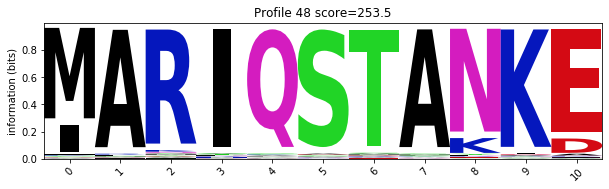

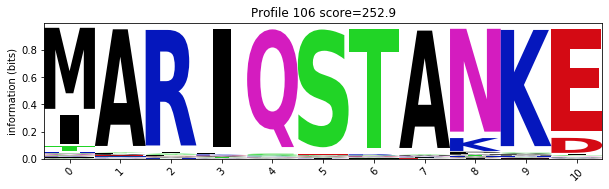

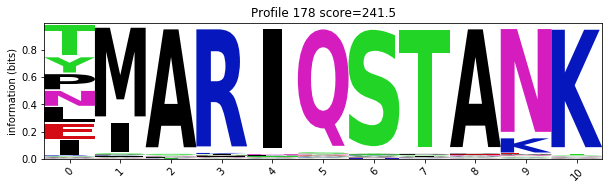

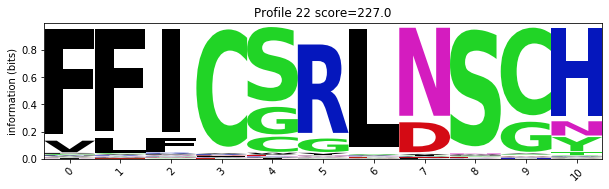

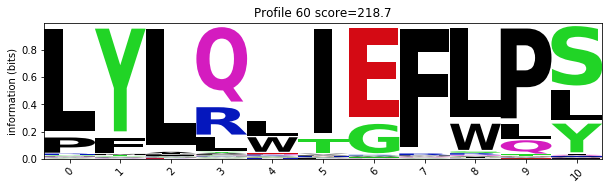

In [13]:
P = specProModel.getP()
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']

In [14]:
# dataset = tf.data.Dataset.from_tensor_slices([X])